In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import itertools

In [20]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [21]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    print("data", data[:15])
    print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [22]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data.dropna(inplace=True)
    # data.reset_index(drop=True, inplace=True)


    result = data
    # print(result.head(10))
    return result

In [23]:
def prepare_data(df, target_column, n_steps):

    df = modify_data(df)

    # print(df.head(10))

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    # print(features.head(10))
    features = features.drop(columns = ['Date'])

    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    


    X, y = create_sequences(features_scaled, target, n_steps)
    for i in range(15):
        print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = False)

    return X_train, X_test, y_train, y_test

In [24]:
df = load_data("./input/copper_log_returns_5d_final.csv")
target_column = 'LMCADY_acu_5d_log'
X_train, X_test, y_train, y_test = prepare_data(df, target_column, 10)

Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
data [[ 6.62310310e-01  6.80932623e-01  1.42118114e-01  1.61051778e+00
   1.36632501e+00  1.49240048e+00 -2.64682715e-01 -1.23028213e-01
   1.12317286e+00]
 [-7.02585040e-01 -7.29611549e-01 -1.46089489e+00 -2.82465841e-02
  -1.38652877e+00  2.61753597e-01  4.96497959e-01  2.28305037e-01
   3.97697680e-01]
 [ 4.16730896e-01  3.73733394e-01  4.93186010e-01 -1.47816083e-01
   3.59611552e-01  5.10355482e-02 -8.45441003e-02 -3.68017847e-01
   2.88056075e-01]
 [ 6.76295977e-01  6.48856861e-01 -5.37108957e-01  4.68251054e-01
  -4.55764160e-02  6.89113778e-01 -8.79111041e-01 -7.70203832e-01
   7.34192270e-01]
 [ 3.90303392e-01  3.48598393e-01  2.66731036e-01 -1.26614650e+00
   9.43627445e-01 -1.13109610e+00 -1.91565422e-01  3.77407948e-02
   6.26802012e-01]
 [ 2.39653665e-01  2.82488249e-01 -1.13779449e+00 -3.64097816e-01
   8.34974442e-01 -3.35016962e-01  1.736

In [25]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [26]:
# model_params = {
#     'n_steps': n_steps,
#     'rnn_units': rnn_units,
#     'activation': activation,
#     'dropout': dropout
# }

def build_model(input_shape, md_prm: dict):
    model = Sequential()
    model.add(SimpleRNN(md_prm['rnn_units'], activation=md_prm['activation'], input_shape=input_shape))
    model.add(Dropout(md_prm['dropout']))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return model

In [27]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

In [28]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [29]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data", markersize=4):
    # Asegurarse de que n no sea mayor que el número de puntos disponibles
    n = min(n, len(y_true), len(y_pred))

    # Usar slicing para obtener los últimos n valores
    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7) 

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [30]:
# n_steps: 5, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 16, epochs: 100

# n_steps_options = [5, 10, 15, 20, 25, 30]
# batch_size_options = [32, 64, 128, 256]
# epochs_options = [100, 200, 300, 400]
# rnn_units_options = [50, 100, 150, 200]
n_steps_options = [10]
batch_size_options = [16,32]
epochs_options = [100]

rnn_units_options = [50]
activation_options = ['tanh','relu']
dropout_options = [0.1]

model_params_combinations = list(itertools.product(
    n_steps_options, 
    rnn_units_options, 
    activation_options, 
    dropout_options,
    batch_size_options,
    epochs_options
))
target_column = 'LMCADY_acu_5d_log'

In [31]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 4


In [32]:
def run_model_iterations():
    top_results = []
    i = 1
    for n_steps, rnn_units, activation, dropout, batch_size, epochs in model_params_combinations:
        try:
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("n_steps: {}, rnn_units: {}, activation: {}, dropout: {}".format(n_steps, rnn_units, activation, dropout))

            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)

            model_params = {
                'n_steps': n_steps,
                'rnn_units': rnn_units,
                'activation': activation,
                'dropout': dropout
            }

            model = build_model((X_train.shape[1], X_train.shape[2]), model_params)
            print(model.summary())
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred = model.predict(X_test)
            rmse_score = math.sqrt(mean_squared_error(y_test, y_pred))
            std_dev = np.std(y_test)

            diff = rmse_score - std_dev

            result = {
                'n_steps': n_steps,
                'rnn_units': rnn_units,
                'activation': activation,
                'dropout': dropout,
                'batch_size': batch_size,
                'epochs': epochs,
                'rmse': rmse_score,
                'std_dev': std_dev,
                'diff': diff,
                'predictions': y_pred,
                'true_values': y_test
            }

            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['diff'])[:5]

            print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
            print("Params: ", model_params)
            print("Iteration {}/{} completed".format(i, n_iterations))

        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i+=1

    return top_results

In [33]:
top_3_results = run_model_iterations()


Iteration 1/4
n_steps: 10, rnn_units: 50, activation: tanh, dropout: 0.1
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
data [[ 6.62310310e-01  6.80932623e-01  1.42118114e-01  1.61051778e+00
   1.36632501e+00  1.49240048e+00 -2.64682715e-01 -1.23028213e-01
   1.12317286e+00]
 [-7.02585040e-01 -7.29611549e-01 -1.46089489e+00 -2.82465841e-02
  -1.38652877e+00  2.61753597e-01  4.96497959e-01  2.28305037e-01
   3.97697680e-01]
 [ 4.16730896e-01  3.73733394e-01  4.93186010e-01 -1.47816083e-01
   3.59611552e-01  5.10355482e-02 -8.45441003e-02 -3.68017847e-01
   2.88056075e-01]
 [ 6.76295977e-01  6.48856861e-01 -5.37108957e-01  4.68251054e-01
  -4.55764160e-02  6.89113778e-01 -8.79111041e-01 -7.70203832e-01
   7.34192270e-01]
 [ 3.90303392e-01  3.48598393e-01  2.66731036e-01 -1.26614650e+00
   9.43627445e-01 -1.13109610e+00 -1.91565422e-01  3.77407948e-02
   6.26802012e-01]
 [ 2.39653665e-01  2.82488249e-0

None
Restoring model weights from the end of the best epoch: 13.
Epoch 23: early stopping
26/26 [==============================] - 0s 997us/step
RMSE: 0.015392, STD_DEV: 0.030739, DIFF: -0.015348
Params:  {'n_steps': 10, 'rnn_units': 50, 'activation': 'tanh', 'dropout': 0.1}
Iteration 1/4 completed

Iteration 2/4
n_steps: 10, rnn_units: 50, activation: tanh, dropout: 0.1
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
data [[ 6.62310310e-01  6.80932623e-01  1.42118114e-01  1.61051778e+00
   1.36632501e+00  1.49240048e+00 -2.64682715e-01 -1.23028213e-01
   1.12317286e+00]
 [-7.02585040e-01 -7.29611549e-01 -1.46089489e+00 -2.82465841e-02
  -1.38652877e+00  2.61753597e-01  4.96497959e-01  2.28305037e-01
   3.97697680e-01]
 [ 4.16730896e-01  3.73733394e-01  4.93186010e-01 -1.47816083e-01
   3.59611552e-01  5.10355482e-02 -8.45441003e-02 -3.68017847e-01
   2.88056075e-01]
 [ 6.76295977e-01  6.48856861e-01 

In [34]:
top_3_results = sorted(top_3_results, key=lambda x: x['diff'])[:5]

Top 1 
RMSE: 0.014616, STD_DEV: 0.030739, DIFF: -0.016123
n_steps: 10, rnn_units: 50, activation: tanh, dropout: 0.1, batch_size: 32, epochs: 100


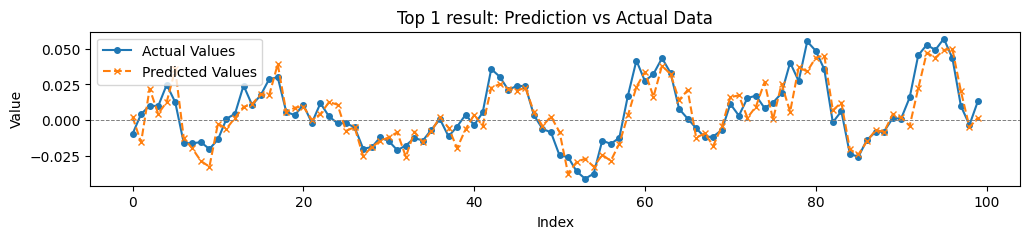

Top 2 
RMSE: 0.015025, STD_DEV: 0.030739, DIFF: -0.015714
n_steps: 10, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 32, epochs: 100


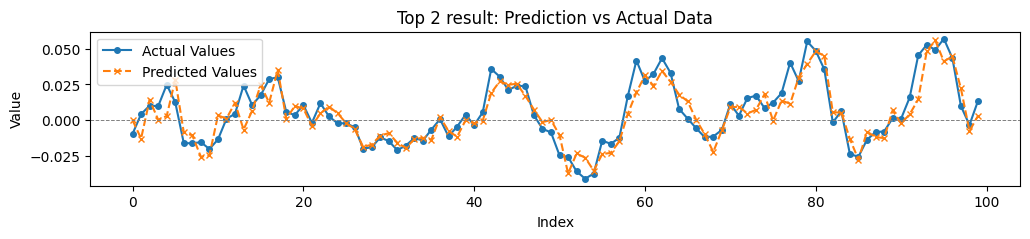

Top 3 
RMSE: 0.015392, STD_DEV: 0.030739, DIFF: -0.015348
n_steps: 10, rnn_units: 50, activation: tanh, dropout: 0.1, batch_size: 16, epochs: 100


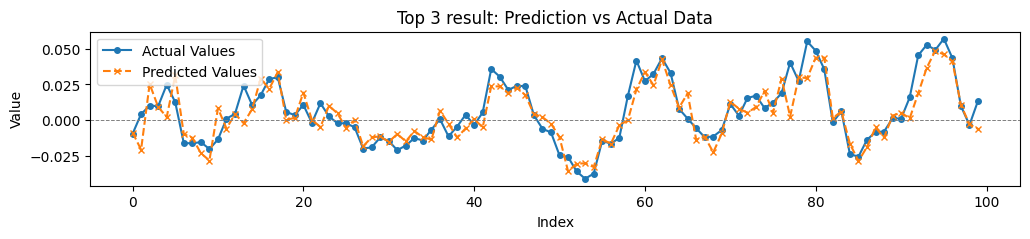

Top 4 
RMSE: 0.015764, STD_DEV: 0.030739, DIFF: -0.014975
n_steps: 10, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 16, epochs: 100


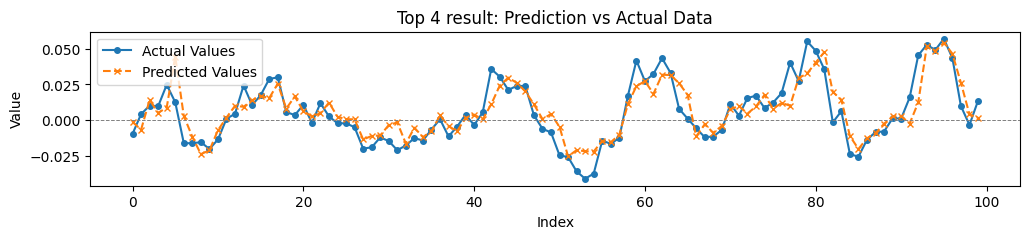

In [35]:
for i,result in enumerate(top_3_results,1):
    print(f"Top {i} ")
    print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(result['rmse'], result['std_dev'], result['diff']))
    print("n_steps: {}, rnn_units: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['rnn_units'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    plot_predictions(result['true_values'], result['predictions'], 100, title=f"Top {i} result: Prediction vs Actual Data")

In [36]:
# export the best result predictions and true values to a csv file
best_result = top_3_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('./output/rnn_best_result.csv', index=False)